In [ ]:
import numpy as np
import glob
import pandas as pd
import os
import cv2
import re
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import plotly.figure_factory as ff
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
import datetime, os
from sklearn.metrics import confusion_matrix
import seaborn as sn
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import matplotlib.pyplot
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.callbacks import LearningRateScheduler

  IMAGE CLASSIFICATION

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
def visualize(image):
    fig = go.Figure(go.Image(z=image))
    fig.update_layout(width=300, height=300, margin=dict(l=10, r=10, b=10, t=10))
    fig.show(renderer="notebook")

In [ ]:
def load_imgs(folder, dims):
    images = []
    path = []
    labels = []
    sample_nrs = []
    img_types = []
    sample_names = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            img_torgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_resized = cv2.resize(img_torgb, dims)
            tmp = filename.split('.')[0]
            label = re.split('(\d+)',tmp)[0]
            sample_name = re.split("([A-Z][^A-Z]*)", label)[0]
            if label == 'mix': continue
            sample_nr = re.split('(\d+)',tmp)[1]
            img_type = re.split('(\d+)',tmp)[2][0]
            images.append(img_resized) 
            path.append(os.path.join(folder,filename))
            labels.append(label)
            sample_nrs.append(sample_nr)
            img_types.append(img_type)
            sample_names.append(sample_name)
    return images,path,labels,sample_nrs,img_types,sample_names

In [ ]:
%%time
folder = '/content/drive/MyDrive/FOOD/'
dims = (128,128)
images, path, labels, sample_nrs, img_types,sample_names = load_imgs(folder,dims)
food_df = pd.DataFrame()
food_df['labels'] = labels
food_df['path'] = path
food_df['sample_nrs'] = sample_nrs
food_df['img_types'] = img_types
food_df['sample_names'] = sample_names
food_df['sample_names_nrs'] = food_df['sample_names'] + food_df['sample_nrs']
food_df['weight'] = 0

CPU times: user 17.8 s, sys: 1.78 s, total: 19.6 s
Wall time: 1min 11s


In [ ]:
density_df = pd.read_excel('/content/drive/MyDrive/density.xls',sheet_name=None)

In [ ]:
for index, row in food_df.iterrows():
    sample_name_nr = row["sample_names_nrs"]
    sample_name = row['sample_names']
    tmp = density_df[sample_name]
    tmp = tmp[tmp['id']==sample_name_nr]
    weight = tmp['weight(g)']
    food_df.loc[index,'weight'] = float(weight)

In [ ]:
food_df

,labels,path,sample_nrs,img_types,sample_names,sample_names_nrs,weight
0,lemon,/content/drive/MyDrive/FOOD/lemon001T(11).JPG,001,T,lemon,lemon001,94.2
1,orange,/content/drive/MyDrive/FOOD/orange008S(10).JPG,008,S,orange,orange008,232.5
2,apple,/content/drive/MyDrive/FOOD/apple008T(1).JPG,008,T,apple,apple008,238.0
3,pear,/content/drive/MyDrive/FOOD/pear003S(12).JPG,003,S,pear,pear003,280.0
4,mooncake,/content/drive/MyDrive/FOOD/mooncake002T(4).JPG,002,T,mooncake,mooncake002,43.8
...,...,...,...,...,...,...,...
2865,qiwi,/content/drive/MyDrive/FOOD/qiwi005S(5).JPG,005,S,qiwi,qiwi005,196.0
2866,apple,/content/drive/MyDrive/FOOD/apple016T(12).JPG,016,T,apple,apple016,272.5
2867,mooncake,/content/drive/MyDrive/FOOD/mooncake001S(12).JPG,001,S,mooncake,mooncake001,39.9
2868,fired_dough_twist,/content/drive/MyDrive/FOOD/fired_dough_twist0...,002,S,fired_dough_twist,fired_dough_twist002,45.9


(128, 128, 3)



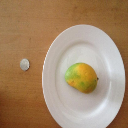

In [ ]:
def show_img(img, label):
    fig = px.imshow(img)
    fig.update_layout(title=label)
    fig.show()
import random

idx = random.randint(0, len(images) - 1)
img = images[idx]
label = labels[idx]
print(img.shape)
show_img(img, label)


In [ ]:
images = np.array(images)
holdout_per = 0.2
y_holdout = food_df.groupby('labels')['labels'].sample(frac=holdout_per,random_state=42)
val_per = 0.5
y_val = y_holdout.sample(frac=val_per,random_state=42)
y_val_idx = y_val.index
y_test = y_holdout.drop(y_val.index)
y_test_idx = y_test.index
X_test = images[y_test_idx]
idx_to_rmv = y_holdout.index
y_train = food_df.drop(idx_to_rmv)['labels']
y_train_idx = y_train.index
y_temp = pd.concat([y_train, y_val, y_test])
y_temp = pd.get_dummies(y_temp)

X_train = np.delete(images, idx_to_rmv, axis=0)
#X_train = X_train.reshape(-1, 128, 128, 1)

y_train = y_temp[0:len(y_train)]
X_val = images[y_val_idx]
y_val = y_temp[len(y_train):len(y_train)+len(y_val)]
y_test = y_temp[len(y_train)+len(y_val):]
print(X_train.shape)

(2295, 128, 128, 3)


VGG model

In [ ]:
'''
from keras.applications import VGG16
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dropout
from keras.layers import Dense

# Define the model architecture
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(19, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the weights of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model.summary()
# Define learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.4)

learning_rate_scheduler = LearningRateScheduler(lr_scheduler)
model_checkpoint = ModelCheckpoint('checkpoints/cl/best_model.h5', save_best_only=True, save_weights_only=False, monitor='val_loss', mode='min')

# Train model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping, learning_rate_scheduler, model_checkpoint])

# Get predictions on test set
y_pred = model.predict(X_test)

# Evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)
'''

"\n!pip install regnet-keras\nfrom regnet.keras import RegNetX_200MF\nfrom keras.layers import *\nfrom keras.callbacks import ModelCheckpoint\n\n# Define the model architecture\nbase_model = RegNetX_200MF(weights='imagenet', include_top=False, input_shape=(128, 128, 3))\nx = base_model.output\nx = GlobalAveragePooling2D()(x)\nx = Dropout(0.5)(x)\nx = Dense(512, activation='relu')(x)\nx = Dropout(0.5)(x)\nx = Dense(128, activation='relu')(x)\npredictions = Dense(19, activation='softmax')(x)\n\nmodel = Model(inputs=base_model.input, outputs=predictions)\n\n# Freeze the weights of the base model\nfor layer in base_model.layers:\n    layer.trainable = False\n\n# Compile model\nmodel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])\n\n# Define early stopping callback\nearly_stopping = EarlyStopping(monitor='val_loss', patience=5)\n\n# Define learning rate scheduler\ndef lr_scheduler(epoch, lr):\n    if epoch < 10:\n        return lr\n    else:\n        return

DenseNet model


In [ ]:
'''
from keras.applications import DenseNet121
from keras.layers import GlobalAveragePooling2D, Dropout, Dense
from keras.models import Model
from keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint

# Define the model architecture
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(19, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the weights of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
# Define learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.4)

learning_rate_scheduler = LearningRateScheduler(lr_scheduler)
model_checkpoint = ModelCheckpoint('checkpoints/cl/best_model.h5', save_best_only=True, save_weights_only=False, monitor='val_loss', mode='min')

# Train model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping, learning_rate_scheduler, model_checkpoint])

# Get predictions on test set
y_pred = model.predict(X_test)

# Evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)
'''

"\nfrom keras.applications import EfficientNetB0\nfrom keras.layers import *\nfrom keras.callbacks import ModelCheckpoint\n\n# Define the model architecture\nbase_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(128, 128, 3))\nx = base_model.output\nx = GlobalAveragePooling2D()(x)\nx = Dropout(0.5)(x)\nx = Dense(512, activation='relu')(x)\nx = Dropout(0.5)(x)\nx = Dense(128, activation='relu')(x)\npredictions = Dense(19, activation='softmax')(x)\n\nmodel = Model(inputs=base_model.input, outputs=predictions)\n\n# Freeze the weights of the base model\nfor layer in base_model.layers:\n    layer.trainable = False\n\n# Compile model\nmodel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])\n\n# Define early stopping callback\nearly_stopping = EarlyStopping(monitor='val_loss', patience=5)\n\n# Define learning rate scheduler\ndef lr_scheduler(epoch, lr):\n    if epoch < 10:\n        return lr\n    else:\n        return lr * tf.math.exp(-

Simple CNN model

In [ ]:

from keras.layers import *
from keras.callbacks import ModelCheckpoint

# Define the model architecture
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=(128, 128, 3), activation='relu'))

model.add(Dropout(0.2)) # Add dropout layer
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Dropout(0.2)) # Add dropout layer
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Dropout(0.2)) # Add dropout layer
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(Dropout(0.2)) # Add dropout layer
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(Dropout(0.2)) # Add dropout layer
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5)) # Add dropout layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5)) # Add dropout layer
model.add(Dense(19, activation='softmax'))

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model.summary()
# Define learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.4)

learning_rate_scheduler = LearningRateScheduler(lr_scheduler)
model_checkpoint = ModelCheckpoint('checkpoints/cl/best_model.h5', save_best_only=True, save_weights_only=False, monitor='val_loss', mode='min')

# Train model
history = model.fit(X_train, y_train, epochs=50, batch_size=256, validation_data=(X_val, y_val), callbacks=[early_stopping, learning_rate_scheduler, model_checkpoint])

# Get predictions on test set
y_pred = model.predict(X_test)

# Evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)


In [ ]:
_, accuracy = model.evaluate(X_train, y_train)
print('Train Accuracy: %.2f' % (accuracy*100))
_, accuracy = model.evaluate(X_val, y_val)
print('Validation Accuracy: %.2f' % (accuracy*100))

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [ ]:
from keras.models import load_model

model_load = load_model('checkpoints/cl/best_model.h5')


In [ ]:
y_pred = model_load.predict(X_test)
y_pred = np.argmax(y_pred,axis=1)
y_true = np.argmax(np.array(y_test),axis=1)
print(classification_report(y_true, y_pred, target_names=y_train.Cylinders))

9/9 [==============================] - 0s 7ms/step
                   precision    recall  f1-score   support

            apple       1.00      0.96      0.98        24
           banana       0.90      0.82      0.86        11
            bread       0.83      0.91      0.87        11
              bun       1.00      0.89      0.94         9
         doughnut       0.88      0.96      0.92        23
              egg       0.89      1.00      0.94         8
fired_dough_twist       1.00      0.83      0.91        12
            grape       1.00      1.00      1.00         8
            lemon       1.00      1.00      1.00        15
           litchi       1.00      1.00      1.00         8
            mango       0.87      1.00      0.93        20
         mooncake       1.00      0.92      0.96        12
           orange       1.00      0.94      0.97        33
            peach       1.00      1.00      1.00        13
             pear       0.94      1.00      0.97        16
    

In [ ]:
import plotly.figure_factory as ff

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 

fig = ff.create_annotated_heatmap(
    np.array(confusion_mtx), 
    x=list(y_train.columns), 
    y=list(y_train.columns), 
    colorscale='magma', 
    showscale=True)

fig.update_layout(
    title='Confusion Matrix', 
    xaxis_title='Predicted', 
    yaxis_title='True')
fig.update_yaxes(autorange="reversed")

fig.show(renderer="colab")


CALORIES ESTIMATION

In [ ]:
import glob
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn
import xml.etree.ElementTree as ET
!pip install opencv-python
import pandas as pd                     


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
densities = pd.read_excel("/content/drive/MyDrive/density.xls", sheet_name=None)
# Types of foods
classes = [i for i in densities.keys()]


In [ ]:
calories = {'apple': 0.52, 'banana': 0.89, 'bread': 3.15, 'bun': 2.23, 'doughnut': 4.34, 'egg': 1.43,
            'fired_dough_twist': 24.16, 'grape': 0.69, 'lemon': 0.29, 'litchi': 0.66, 'mango': 0.60,
            'mooncake': 18.83, 'orange': 0.63, 'peach': 0.57, 'pear': 0.39, 'plum': 0.46, 'qiwi': 0.61,
            'sachima': 21.45, 'tomato': 0.27}

food_densities = {'apple': 0.78, 'banana': 0.91, 'bread': 0.18, 'bun': 0.34, 'doughnut': 0.31, 'egg': 1.03,
                  'fired_dough_twist': 0.58, 'grape': 0.97, 'lemon': 0.96, 'litchi': 1.00, 'mango': 1.07,
                  'mooncake': 0.96, 'orange': 0.90, 'peach': 0.96, 'pear': 1.02, 'plum': 1.01, 'qiwi': 0.97,
                  'sachima': 0.22, 'tomato': 0.98}

In [ ]:
mix = densities['mix'].mean(axis=0)     # label = 11
mix_cal = round(sum(calories.values())/len(calories), 2)        # mean calorie of mix labelled images
mix_density = round(mix['weight(g)'] / mix['volume(mm^3)'], 2)  # mean density of mix labelled images

<ipython-input-24-0aacd541bb07>:1: FutureWarning:

The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.



In [ ]:
def get_food_df():
      df = pd.DataFrame(Cylinders=['food', 'density', 'calorie'])
      f = 0
      for food in classes:
          if food != 'mix':
              df.loc[f] = [food, food_densities[food], calories[food]]
              f += 1
          else:
              df.loc[f] = [food, mix_density, mix_cal]
              f += 1

      return df

def get_bbox(annotations, food_boxes, coin_boxes):      # get box coordinates of food and coin from xml file
    # Get food's and coin's bounding box
        for path in annotations:
            food = ET.parse(path)
            root = food.getroot()
            temp = 0
            for child in root.findall('object'):
                box = child.find('bndbox')
                xmin = int(box[0].text)
                ymin = int(box[1].text)
                xmax = int(box[2].text)
                ymax = int(box[3].text)
                if temp == 0:
                    food_boxes.append((xmin, ymin, xmax, ymax))
                else:
                    coin_boxes.append((xmin, ymin, xmax, ymax))
                temp += 1

        return food_boxes, coin_boxes
def create_df(food_bbox, coin_bbox):

    df = pd.DataFrame(Cylinders=['id', 'label', 'food_bbox', 'coin_bbox'])
    labels = dict(zip(classes, range(0, 20)))
    for i in range(len(food_imgs)):
        name = food_imgs[i][food_imgs[i].index("/") + 1:food_imgs[i].index(".JPG")]
        
        #name = food_imgs[i][food_imgs[i].index("\\") + 1:food_imgs[i].index(".JPG")]
        for c in classes:
            if c in name:
                df.loc[i] = [name, labels[c], food_bbox[i], coin_bbox[i]]

    return df
def image_data(datalist, df):

        for path in df['id'].values:
            path = "/" + path + ".JPG"
            try:
                image=cv2.imread(path)
                image=np.resize(image, (128, 128))
                datalist.append(image)
            except Exception as e:
                print(str(e))
        # normalize data, all pixel values in range [0,1]
        datalist = np.array(datalist, dtype="float") / 255.0
        return datalist




In [ ]:
import os

path = '/content/drive/MyDrive/Annotations/peach004T(5).xml'
print(os.path.isdir(path))


False


In [ ]:
import os
food_imgs = []
for path in glob.glob("/content/drive/MyDrive/FOOD/*.JPG"):
    if path == '/content/drive/MyDrive/FOOD\\mix002T(2).JPG':
        continue
    elif path == '/content/drive/MyDrive/FOOD\\mix005S(4).JPG':
        continue
    else: food_imgs.append(path)
      
annotations = glob.glob("/content/drive/MyDrive/Annotations/*.xml")
food_bbox, coin_bbox = get_bbox(annotations, [], [])
info = create_df(food_bbox, coin_bbox)
food_df = get_food_df()
print(food_df.head())
print(info.head())
info2 = info[['id','label']]
info2['food_item']=info2['id'].str.split("/",n=5,expand=True)[4].str.split("0",n=1,expand=True)[0]
print(info2.head())


       food  density  calorie
0     apple     0.78     0.52
1    banana     0.91     0.89
2     bread     0.18     3.15
3       bun     0.34     2.23
4  doughnut     0.31     4.34
                                           id  label             food_bbox  \
0    content/drive/MyDrive/FOOD/lemon001T(11)      8  (464, 191, 577, 436)   
1   content/drive/MyDrive/FOOD/orange008S(10)     13  (409, 233, 655, 455)   
2     content/drive/MyDrive/FOOD/apple008T(1)      0  (422, 271, 553, 369)   
3     content/drive/MyDrive/FOOD/pear003S(12)     14  (360, 191, 617, 471)   
4  content/drive/MyDrive/FOOD/mooncake002T(4)     12  (441, 257, 627, 383)   

              coin_bbox  
0  (164, 207, 235, 271)  
1  (119, 169, 187, 228)  
2  (135, 329, 200, 388)  
3  (140, 138, 208, 201)  
4  (156, 347, 218, 402)  
                                           id  label food_item
0    content/drive/MyDrive/FOOD/lemon001T(11)      8     lemon
1   content/drive/MyDrive/FOOD/orange008S(10)     13    orange
2     

In [ ]:
xtr, xtest, y_train, y_test = train_test_split(info, info.label, test_size=0.3, random_state=42)
xtest, xval, y_test, y_val = train_test_split(xtest, y_test, test_size=0.5, random_state=42)

indices = list(xtest.index)

X_train = image_data([], xtr)
X_val = image_data([], xval)
X_test = image_data([], xtest)

print(X_test)

[[[0.18039216 0.43137255 0.61960784 ... 0.61176471 0.15686275 0.40784314]
  [0.59607843 0.16078431 0.41176471 ... 0.44705882 0.63921569 0.18823529]
  [0.45098039 0.64313725 0.18823529 ... 0.20392157 0.44705882 0.63529412]
  ...
  [0.89803922 0.90980392 0.88235294 ... 0.86666667 0.89411765 0.90588235]
  [0.86666667 0.89019608 0.90980392 ... 0.90588235 0.85490196 0.87843137]
  [0.89803922 0.85098039 0.8745098  ... 0.85882353 0.87843137 0.83921569]]

 [[0.18039216 0.41568627 0.58039216 ... 0.6627451  0.26666667 0.50196078]
  [0.66666667 0.2627451  0.49803922 ... 0.50588235 0.66666667 0.2627451 ]
  [0.50588235 0.66666667 0.26666667 ... 0.31764706 0.52156863 0.67843137]
  ...
  [0.74509804 0.86666667 0.63921569 ... 0.63921569 0.75294118 0.8745098 ]
  [0.63137255 0.74117647 0.8745098  ... 0.85490196 0.6        0.72156863]
  [0.85098039 0.59607843 0.71764706 ... 0.63529412 0.77254902 0.50588235]]

 [[0.59607843 0.53333333 0.48235294 ... 0.52156863 0.61960784 0.54509804]
  [0.51372549 0.627450

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
class MLP(Sequential):
    def __init__(self, input_shape):
        super().__init__()
        
        self.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
        self.add(MaxPooling2D((2, 2)))
        self.add(Conv2D(64, (3, 3), activation='relu'))
        self.add(MaxPooling2D((2, 2)))
        self.add(Conv2D(128, (3, 3), activation='relu'))
        self.add(MaxPooling2D((2, 2)))
        self.add(Flatten())
        self.add(Dense(128, activation='relu'))
        self.add(Dense(1, activation='relu'))
    def locations(self,df, idx):
        food_box = df.iloc[idx]['food_bbox']
        coin_box = df.iloc[idx]['coin_bbox']

        width_food, height_food = (food_box[2] - food_box[0], food_box[3] - food_box[1])
        width_coin, height_coin = (coin_box[2] - coin_box[0], coin_box[3] - coin_box[1])

        return (food_box[0], food_box[1], width_food, height_food), (coin_box[0], coin_box[1], width_coin, height_coin)
    def draw_plots(self,history):
        # summarize history for loss and accuracy
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='best')
        plt.show()

        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='best')
        plt.show()
    def grab_cut(self,image, box):
        # read the image
        image = cv2.imread(image)
        # convert to RGB from default BGR
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # copy the original image
        img = image.copy()
        # create a mask with shape (width, height)
        mask = np.zeros(img.shape[:2], np.uint8)
        background = np.zeros((1, 65), np.float64)
        foreground = np.zeros((1, 65), np.float64)
        cv2.grabCut(img, mask, box, background, foreground, 5, cv2.GC_INIT_WITH_RECT)
        mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
        segmented = img * mask2[:, :, np.newaxis]
        return segmented
    def food_area(self,food_img):            # find the area of food in the image by using contours
        _, thresh = cv2.threshold(cv2.cvtColor(food_img, cv2.COLOR_BGR2GRAY), 40, 255, 0)
        contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

        area = 0
        cnt = None
        for c in contours:
            if cv2.contourArea(c) > 0:
                area = cv2.contourArea(c)
                cnt = c

        x, y, w, h = cv2.boundingRect(cnt)
        # rect_area = w * h
        cv2.rectangle(food_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        print('height:', h)
        return area*0.000676 , h*0.026
    def coin_area(self,coin_img):        # find the area of coin in the image by using contours
        coin_img = cv2.cvtColor(coin_img, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(coin_img, 40, 255, 0)
        contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

        if len(contours) == 0:      # if contour cannot find, assign 1 to its area value, 0,025 to its scale factor

        #1 pixel = 0.025 cm
            area_coin = 1*0.000676
            pixel2cm = 0.026
        else:
            cont = max(contours, key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(cont)
            cv2.rectangle(coin_img, (x, y), (x + w, y + h), (0, 255, 0), 1)
            pixel2cm = 2.5 / (h)                        # 1 pixel is ... cm
            area_coin = cv2.contourArea(cont)*0.000676
        return area_coin, pixel2cm
    
    def get_volume(self, idx, label, df):
        food_box, coin_box = self.locations(df, idx)
        shape = {'Sphere': [0, 5, 8, 13, 14, 16, 17, 19],
            'Cylinder': [2, 7, 12, 18],
            'irregular': [1, 3, 4, 6, 9, 10, 15]}
        food = self.grab_cut(food_imgs[idx], food_box)
        coin = self.grab_cut(food_imgs[idx], coin_box)

        area_food, height = self.food_area(food)
        area_coin, px2cm = self.coin_area(coin)
        
        if area_coin == 0:
            area_coin = 1
        ratio = (area_food / area_coin)
        
        
        if label in shape['Sphere']:
            rad = np.sqrt(area_food / np.pi)
            volume = ((4 / 3) * np.pi * (rad ** 3))*4
            shape_ret='Sphere'
            print("Sphere")
            print(volume)

        elif label in shape['Cylinder']:
            #height = height * px2cm
            rad = area_food / (2.0 * height * np.pi)    #area_food = 2 * pi * r * h
            volume = np.pi * rad * rad * height
            shape_ret='Cylinder'
            print("Cylinder")
            print(volume)

        elif label in shape['irregular']:
            #height = height * px2cm
            volume = area_food * height
            shape_ret='irregular'
            print("Irregular")
            print(volume)

        else:
            volume = ratio * px2cm
            shape_ret='else'
            print("else")
            print(volume)
            # volume = 0

        return volume,shape_ret

    def get_calorie(self, volume, density, c):
        # c = calories per gram
        mass = volume * density
        return c * mass



model = MLP(input_shape=(128, 128, 1))
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mean_squared_error', metrics=['mae'])
history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_val, y_val), shuffle=True)


Exception ignored in: <function _xla_gc_callback at 0x7f3098368dc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


Epoch 1/50
66/66 [==============================] - 3s 20ms/step - loss: 53.1335 - mae: 6.0678 - val_loss: 41.5524 - val_mae: 5.5636
Epoch 2/50
66/66 [==============================] - 1s 17ms/step - loss: 38.7073 - mae: 5.4114 - val_loss: 36.7207 - val_mae: 5.2700
Epoch 3/50
66/66 [==============================] - 1s 18ms/step - loss: 36.5955 - mae: 5.2504 - val_loss: 36.4720 - val_mae: 5.2551
Epoch 4/50
66/66 [==============================] - 1s 18ms/step - loss: 36.2335 - mae: 5.2420 - val_loss: 35.8376 - val_mae: 5.1887
Epoch 5/50
66/66 [==============================] - 1s 17ms/step - loss: 35.7203 - mae: 5.1856 - val_loss: 35.2290 - val_mae: 5.1523
Epoch 6/50
66/66 [==============================] - 1s 18ms/step - loss: 35.6275 - mae: 5.1735 - val_loss: 35.0089 - val_mae: 5.1359
Epoch 7/50
66/66 [==============================] - 1s 19ms/step - loss: 34.9538 - mae: 5.1254 - val_loss: 36.8493 - val_mae: 5.1963
Epoch 8/50
66/66 [==============================] - 1s 19ms/step - lo

In [ ]:
print(X_train)
print(y_train.value_counts().index)

[[[0.21568627 0.28627451 0.44705882 ... 0.36470588 0.14117647 0.22745098]
  [0.36470588 0.11764706 0.20392157 ... 0.11372549 0.24705882 0.07843137]
  [0.11764706 0.25098039 0.08627451 ... 0.09019608 0.1372549  0.27058824]
  ...
  [0.18431373 0.31372549 0.14901961 ... 0.13333333 0.16862745 0.29803922]
  [0.12941176 0.16862745 0.30196078 ... 0.29019608 0.1254902  0.16078431]
  [0.29019608 0.1254902  0.16078431 ... 0.16078431 0.27843137 0.11764706]]

 [[0.42352941 0.53333333 0.67058824 ... 0.70196078 0.38823529 0.54901961]
  [0.6745098  0.38039216 0.54117647 ... 0.53333333 0.67058824 0.37254902]
  [0.5372549  0.6745098  0.37254902 ... 0.37254902 0.51372549 0.67058824]
  ...
  [0.47058824 0.65098039 0.23529412 ... 0.23921569 0.48235294 0.63921569]
  [0.24313725 0.47843137 0.64313725 ... 0.62352941 0.21568627 0.45882353]
  [0.63921569 0.21960784 0.4627451  ... 0.48235294 0.63921569 0.23137255]]

 [[0.23921569 0.44313725 0.60392157 ... 0.6627451  0.34901961 0.52156863]
  [0.66666667 0.321568

In [ ]:
info["label"].value_counts().index

Int64Index([0, 13, 10, 4, 1, 16, 19, 14, 8, 18, 12, 15, 6, 17, 11, 5, 3, 9, 2,
            7],
           dtype='int64')

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
# import numpy as np
# np.round(model.predict(test_data)).astype(int)


1/1 [==============================] - 0s 102ms/step


array([[ 2],
       [ 0],
       [ 3],
       [ 8],
       [ 6],
       [ 5],
       [ 8],
       [ 7],
       [ 6],
       [10],
       [ 9],
       [18],
       [15],
       [15],
       [14],
       [15],
       [12],
       [19],
       [15],
       [20]])

In [ ]:
import numpy as np
real_mean_volume = [densities[c].mean(axis=0)['volume(mm^3)'] for c in classes]
real_mean_classes = [c for c in classes]
densities_df=pd.DataFrame({'real_mean_volume':real_mean_volume,'real_mean_classes':real_mean_classes})
test_df = info.groupby('label', as_index=False, group_keys=False).apply(lambda s: s.sample(1))
# get 3 random samples from each class
test_data = image_data([], test_df)
test_idxs = list(test_df.index)
# test_yhat = np.round(model.predict(test_data), axis=1)
test_yhat = np.round(model.predict(test_data)).astype(int)



<ipython-input-85-d2705c43caf1>:2: FutureWarning:

The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.

<ipython-input-85-d2705c43caf1>:2: FutureWarning:

The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.

<ipython-input-85-d2705c43caf1>:2: FutureWarning:

The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.

<ipython-input-85-d2705c43caf1>:2: FutureWarning:

The defaul

1/1 [==============================] - 0s 83ms/step


In [ ]:
#Dataset to test volume estimation
densities_df=pd.DataFrame({'real_mean_volume':real_mean_volume,'real_mean_classes':real_mean_classes})
densities_shapes_info=pd.merge(info2[['label','food_item']].drop_duplicates(),densities_df,right_on='real_mean_classes',left_on='food_item',how='inner')
densities_shapes_info.head()
shape = [(densities_shapes_info['label'].isin([0, 5, 8, 13, 14, 16, 17, 19])),(densities_shapes_info['label'].isin([2, 7, 12, 18])),(densities_shapes_info['label'].isin([1, 3, 4, 6, 9, 10, 15]))]
values=['Sphere','Cylinder','irregular']
densities_shapes_info['shape']=np.select(shape,values,default='else')
df_real_mean=densities_shapes_info.groupby('shape')['real_mean_volume'].mean().reset_index()

In [ ]:
# print(real_mean_volume)
# print(len(real_mean_volume))
# print(test_vol_pred)
# print(len(test_vol_pred))


# print(real_mean_classes)

[318.94736842105266, 166.0, 152.85714285714286, 238.75, 192.22222222222223, 51.42857142857143, 67.14285714285714, 345.0, 97.5, 42.0, 104.0, 191.60714285714286, 60.0, 210.66666666666666, 241.66666666666666, 112.0, 112.5, 150.0, 152.0, 185.0]
20
[120.39032719999997, 118.3822692, 184.35378519999998, 40.2894648, 320.635171584, 101.02516070399999, 137.45873232, 93.33277824, 97.021418208, 98.57425780799998, 689.2646342399999, 14.92764832, 330.74175825599997, 28.930605703999994, 206.26639955999997, 69.40665732, 0.004446728, 5.543364943999999, 4.165142904, 0.07056763999999999]
20
['apple', 'banana', 'bread', 'bun', 'doughnut', 'egg', 'fired_dough_twist', 'grape', 'lemon', 'litchi', 'mango', 'mix', 'mooncake', 'orange', 'pear', 'peach', 'plum', 'qiwi', 'sachima', 'tomato']


In [ ]:
test_vol_pred = []
test_vol_shape = []
for i in range(len(test_yhat)):
    idx = test_idxs[i]
    label = test_yhat[i][0]
    volume,shape_ret = model.get_volume(idx, label, info)
    print(label)
    try:
      calorie = model.get_calorie(volume, food_df.iloc[label]['density'], food_df.iloc[label]['calorie'])
    except:
      #Correcting the dataset
      calorie = 0
    test_vol_pred.append(volume)
    test_vol_shape.append(shape_ret)

# df_test_vol = pd.DataFrame('Vol_Pred':test_vol_pred,'Vol_Shape':test_vol_shape)
df_test_vol = pd.DataFrame({'Vol_Pred':test_vol_pred, 'Vol_Shape':test_vol_shape})

df_test_vol_mean=df_test_vol.groupby('Vol_Shape')['Vol_Pred'].mean().reset_index()

height: 286
Height of food: 7.436
Area of food: 44.121168
Height of coin: 0.026
Area of coin: 0.000676
Irregular
656.1700104959999
4
height: 134
Height of food: 3.484
Area of food: 14.79933
Height of coin: 0.026
Area of coin: 0.000676
Irregular
103.12173143999999
9
height: 112
Height of food: 2.912
Area of food: 6.62142
Height of coin: 0.026
Area of coin: 0.000676
ellipsoid
51.26848640568301
5
height: 0
Height of food: 0.0
Area of food: 0.0
Height of coin: 0.026
Area of coin: 0.000676
ellipsoid
0.0
0
height: 95
Height of food: 2.4699999999999998
Area of food: 10.645648
Height of coin: 0.026
Area of coin: 0.000676
Irregular
52.589501119999994
9
height: 131
Height of food: 3.4059999999999997
Area of food: 10.027446
Height of coin: 0.026
Area of coin: 0.000676
Column
23.492333425207228
7
height: 124
Height of food: 3.2239999999999998
Area of food: 6.577818
Height of coin: 0.03164556962025317
Area of coin: 2.0290139999999997
Irregular
42.413770463999995
3
height: 211
Height of food: 5.486


1471.1939407374655

       shape  real_mean_volume
0     column        177.464286
1  ellipsoid        170.963659
2       else        191.607143
3  irregular        131.730726
   Vol_Shape    Vol_Pred
0     column  182.562100
1  ellipsoid  195.761199
3       else  202.719200
2  irregular  177.306563


In [ ]:
df_test_vol_mean=df_test_vol_mean.append({'Vol_Shape':'else','Vol_Pred':202.7192},ignore_index=True)
df_test_vol_mean.loc[df_test_vol_mean['Vol_Pred']==182.562100,'Vol_Shape']='Cylinder'
df_real_mean = df_real_mean.sort_values(by='shape')
df_test_vol_mean = df_test_vol_mean.sort_values(by='Vol_Shape')


<ipython-input-98-200dc68a8c89>:1: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [ ]:
df_test_vol_mean.drop_duplicate()

In [ ]:
print(df_real_mean)
print(df_test_vol_mean)

In [ ]:
# MSE = np.square(np.subtract(real_mean_volume, test_vol_pred)).mean()
MSE = np.square(np.subtract(df_real_mean['real_mean_volume'], df_test_vol_mean['Vol_Pred'])).mean()
MSE